In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

# Collaborative Filtering Deep Dive

## A First Look at the Data

In [3]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [4]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings = ratings[0:1000]

In [5]:
last_skywalker = np.array([0.98,0.9,-0.9])

In [6]:
user1 = np.array([0.9,0.8,-0.6])

In [7]:
(user1*last_skywalker).sum()

2.1420000000000003

In [8]:
casablanca = np.array([-0.99,-0.3,0.8])

In [9]:
(user1*casablanca).sum()

-1.611

## Learning the Latent Factors

## Creating the DataLoaders

In [10]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [11]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,186,302,3,891717742,L.A. Confidential (1997)
4,191,302,4,891560253,L.A. Confidential (1997)


In [12]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,70,Real Genius (1985),3
1,161,Schindler's List (1993),3
2,303,Only You (1994),3
3,33,Love Jones (1997),3
4,246,"City of Lost Children, The (1995)",4
5,305,Pink Floyd - The Wall (1982),2
6,63,Kolya (1996),3
7,59,Taxi Driver (1976),5
8,13,Ben-Hur (1959),3
9,178,"Corrina, Corrina (1994)",4


In [13]:
dls.classes

{'user': ['#na#', 1, 2, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 32, 33, 36, 37, 38, 41, 42, 43, 44, 47, 48, 49, 50, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 72, 73, 77, 78, 79, 81, 82, 83, 84, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 104, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 137, 138, 140, 141, 144, 145, 146, 148, 150, 151, 152, 154, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 177, 178, 180, 181, 182, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 203, 205, 207, 208, 210, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 226, 229, 230, 231, 232, 233, 234, 235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 249, 250, 251, 253, 254, 255, 256, 257, 259, 260, 262, 263, 264, 265, 267, 268, 269, 270, 271, 272, 274, 275, 276, 278, 279, 280, 281, 2

In [14]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [15]:
one_hot_3 = one_hot(3, n_users).float()

In [16]:
user_factors.t() @ one_hot_3

tensor([ 0.6674, -1.3095, -0.4104,  0.4681, -0.2346])

In [17]:
user_factors[3]

tensor([ 0.6674, -1.3095, -0.4104,  0.4681, -0.2346])

## Collaborative Filtering from Scratch

In [18]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

In [19]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'

In [20]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [21]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [22]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [23]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,13.650739,13.569832,00:00
1,13.704095,13.569371,00:00
2,13.647213,13.567824,00:00
3,13.477321,13.566082,00:00
4,13.317433,13.565662,00:00


In [24]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [25]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.917601,1.827637,00:00
1,1.916909,1.827474,00:00
2,1.870044,1.826382,00:00
3,1.799382,1.825157,00:00
4,1.740467,1.824947,00:00


In [26]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [27]:
# model = DotProductBias(n_users, n_movies, 5)
# learn = Learner(dls, model, loss_func=MSELossFlat())
# learn.fit_one_cycle(5, 5e-3)

### Weight Decay

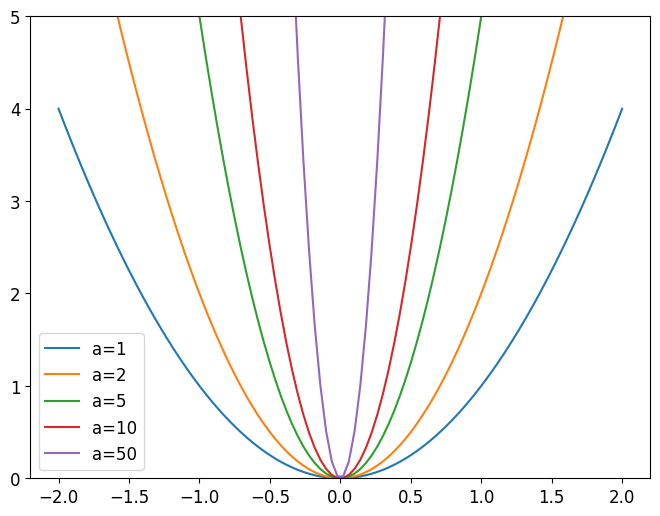

In [28]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [29]:
# model = DotProductBias(n_users, n_movies, 5)
# learn = Learner(dls, model, loss_func=MSELossFlat())
# learn.fit_one_cycle(5, 5e-3, wd=0.1)

### Creating Our Own Embedding Module

In [30]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [31]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [32]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.2298],
        [-0.6846],
        [-0.8508]], requires_grad=True)]

In [33]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [34]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [35]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [36]:
model = DotProductBias(n_users, n_movies, 20)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.928015,1.804726,00:00
1,1.892139,1.746784,00:00
2,1.824805,1.702899,00:00
3,1.747956,1.682027,00:00
4,1.688659,1.678239,00:00


## Interpreting Embeddings and Biases

In [51]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

AttributeError: 'EmbeddingNN' object has no attribute 'movie_bias'

In [38]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Sting, The (1973)',
 'Speed (1994)',
 'Remains of the Day, The (1993)',
 'Top Gun (1986)',
 'Shining, The (1980)']

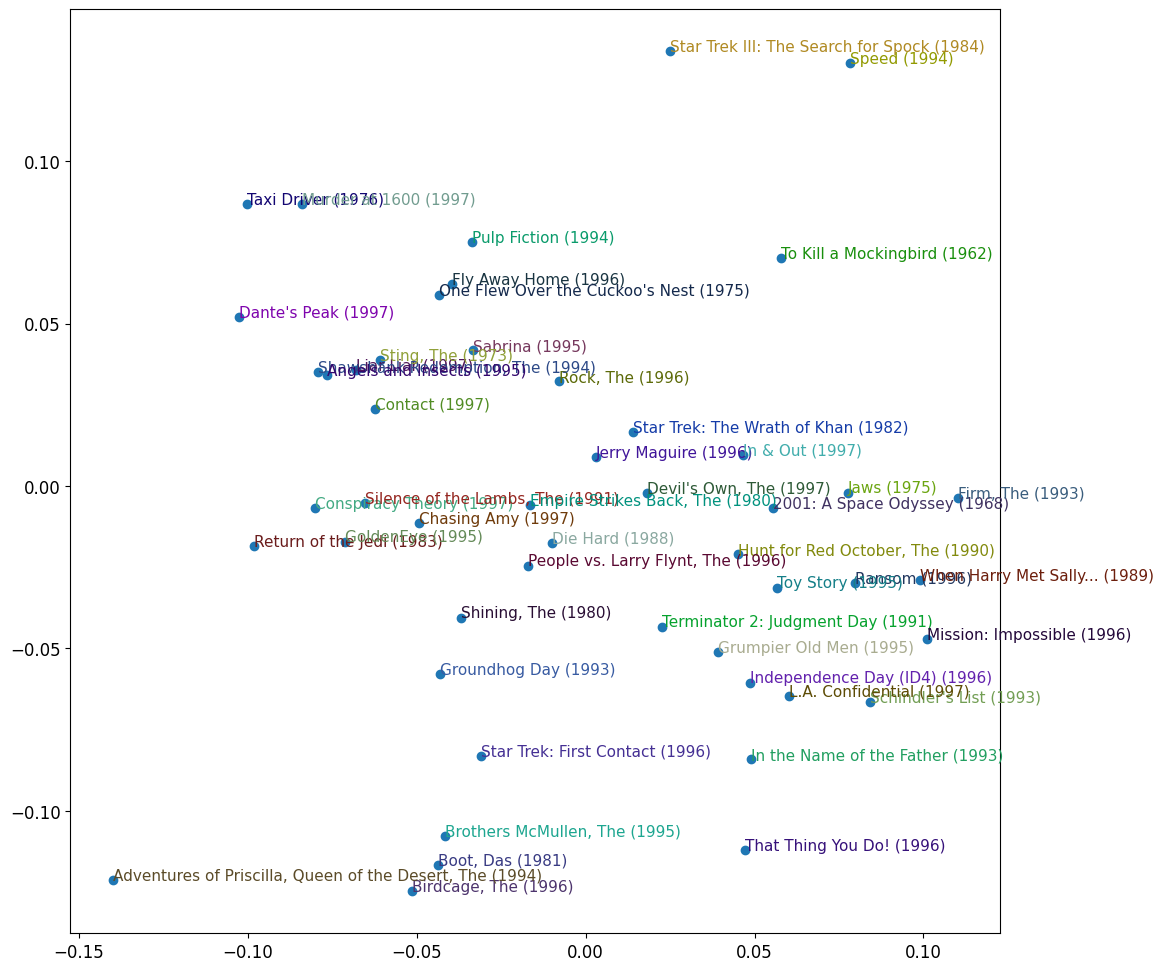

In [39]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Using fastai.collab

In [40]:
learn = collab_learner(dls, n_factors=5, y_range=(0, 5.5))

In [41]:
# learn.fit_one_cycle(5, 5e-3, wd=0.1)

In [42]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(238, 5)
  (i_weight): Embedding(551, 5)
  (u_bias): Embedding(238, 1)
  (i_bias): Embedding(551, 1)
)

In [43]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Under Siege (1992)',
 'Flubber (1997)',
 'Sleepless in Seattle (1993)',
 'Crumb (1994)',
 'Jane Eyre (1996)']

### Embedding Distance

In [44]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

"Ulee's Gold (1997)"

## Bootstrapping a Collaborative Filtering Model

## Deep Learning for Collaborative Filtering

In [45]:
embs = get_emb_sz(dls)
embs

[(238, 34), (551, 55)]

In [46]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [47]:
model = CollabNN(*embs)

In [48]:
learn = Learner(dls, model, loss_func=MSELossFlat())
# learn.fit_one_cycle(5, 5e-3, wd=0.01)

In [49]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
# learn.fit_one_cycle(5, 5e-3, wd=0.1)

In [50]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

### Sidebar: kwargs and Delegates

### End sidebar

## Conclusion

## Questionnaire

1. What problem does collaborative filtering solve?
1. How does it solve it?
1. Why might a collaborative filtering predictive model fail to be a very useful recommendation system?
1. What does a crosstab representation of collaborative filtering data look like?
1. Write the code to create a crosstab representation of the MovieLens data (you might need to do some web searching!).
1. What is a latent factor? Why is it "latent"?
1. What is a dot product? Calculate a dot product manually using pure Python with lists.
1. What does `pandas.DataFrame.merge` do?
1. What is an embedding matrix?
1. What is the relationship between an embedding and a matrix of one-hot-encoded vectors?
1. Why do we need `Embedding` if we could use one-hot-encoded vectors for the same thing?
1. What does an embedding contain before we start training (assuming we're not using a pretained model)?
1. Create a class (without peeking, if possible!) and use it.
1. What does `x[:,0]` return?
1. Rewrite the `DotProduct` class (without peeking, if possible!) and train a model with it.
1. What is a good loss function to use for MovieLens? Why? 
1. What would happen if we used cross-entropy loss with MovieLens? How would we need to change the model?
1. What is the use of bias in a dot product model?
1. What is another name for weight decay?
1. Write the equation for weight decay (without peeking!).
1. Write the equation for the gradient of weight decay. Why does it help reduce weights?
1. Why does reducing weights lead to better generalization?
1. What does `argsort` do in PyTorch?
1. Does sorting the movie biases give the same result as averaging overall movie ratings by movie? Why/why not?
1. How do you print the names and details of the layers in a model?
1. What is the "bootstrapping problem" in collaborative filtering?
1. How could you deal with the bootstrapping problem for new users? For new movies?
1. How can feedback loops impact collaborative filtering systems?
1. When using a neural network in collaborative filtering, why can we have different numbers of factors for movies and users?
1. Why is there an `nn.Sequential` in the `CollabNN` model?
1. What kind of model should we use if we want to add metadata about users and items, or information such as date and time, to a collaborative filtering model?

### Further Research

1. Take a look at all the differences between the `Embedding` version of `DotProductBias` and the `create_params` version, and try to understand why each of those changes is required. If you're not sure, try reverting each change to see what happens. (NB: even the type of brackets used in `forward` has changed!)
1. Find three other areas where collaborative filtering is being used, and find out what the pros and cons of this approach are in those areas.
1. Complete this notebook using the full MovieLens dataset, and compare your results to online benchmarks. See if you can improve your accuracy. Look on the book's website and the fast.ai forum for ideas. Note that there are more columns in the full dataset—see if you can use those too (the next chapter might give you ideas).
1. Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.